In [9]:
import face_recognition
#画像を取得する
known_image = face_recognition.load_image_file("../Messi.jpg")
unknown_image = face_recognition.load_image_file("../unknown.jpg")

#それぞれの顔画像から特徴を抽出する
messi_encoding = face_recognition.face_encodings(known_image)[0]
unknown_encoding = face_recognition.face_encodings(unknown_image)[0]

#ぞれぞれの顔画像の特徴を比較する
results = face_recognition.compare_faces([messi_encoding], unknown_encoding)
print(results)

[True]


In [10]:
from matplotlib import pyplot as plt
import cv2

In [11]:
def draw_face_locations(img, locations):
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.set_axis_off()
    for i, (top, right, bottom, left) in enumerate(locations):
        # 長方形を描画する。
        w, h = right - left, bottom - top
        ax.add_patch(plt.Rectangle((left, top), w, h, ec="r", lw=2, fill=None))
        ax.text(left, top,"Messi")
    plt.show()

[(82, 368, 211, 239), (163, 103, 271, 0)]


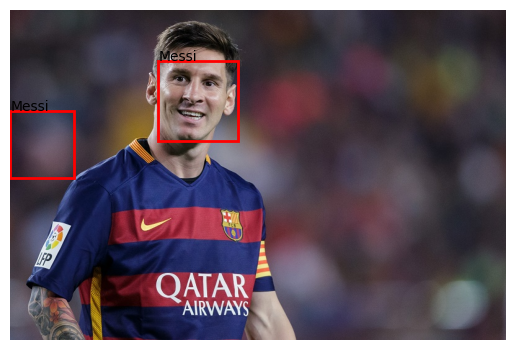

In [12]:
#結果を表示す
face_locations = face_recognition.face_locations(unknown_image)
print(face_locations)
face_names = ["Messi"]
for result in results:
    if result == True:
        face_location = face_locations
        draw_face_locations(unknown_image, face_location)